### Install MLRun

In [1]:
# !pip install mlrun==0.5.4 v3io==0.5.4

In [2]:
# !pip install --upgrade boto3

### Load Config

In [3]:
import yaml
with open("config.yaml") as f:
    config = yaml.safe_load(f)

### Setup Project

In [4]:
import os
from os import path, getenv
import nuclio
from mlrun import new_project, code_to_function, run_local, NewTask, mlconf, import_function, mount_v3io, new_function

project_name = config["project"]["name"]
project_path = path.abspath('project')
project = new_project(name=project_name, context=project_path)
artifact_path = path.abspath('pipeline')
mlconf.dbpath = mlconf.dbpath or 'http://mlrun-api:8080'

print(f'Project name: {project_name}\nProject path: {project_path}')
print(f'Artifacts path: {artifact_path}\nMLRun DB path: {mlconf.dbpath}')

/conda/lib/python3.7/site-packages/requests/__init__.py:91: RequestsDependencyWarning: urllib3 (1.26.2) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)


Project name: dogs-vs-cats-demo
Project path: /User/igz_repos/igz-dogs-vs-cats-pipeline/project
Artifacts path: /User/igz_repos/igz-dogs-vs-cats-pipeline/pipeline
MLRun DB path: http://mlrun-api:8080


### Build Docker Image

In [5]:
image = f"docker-registry.{os.getenv('IGZ_NAMESPACE_DOMAIN')}:80/{config['docker']['s3_image']}"

In [6]:
# # Build Docker Image (only needs to be run once)
# build_image = new_function(name="build-image", kind="job")
# build_image.build_config(
#     image=image, base_image="mlrun/mlrun", commands=["pip install boto3"]
# )
# build_image.deploy(with_mlrun=False)

### Import Functions

In [7]:
project.set_function(func='DownloadS3.ipynb',
                     name='download-s3',
                     kind='job',
                     image=image)
project.set_function(func='PrepData.ipynb',
                     name='prep-data',
                     kind='job',
                     image="mlrun/ml-models-gpu")
project.set_function(func='TrainModel.ipynb',
                     name='train-model',
                     kind='job',
                     image="mlrun/ml-models-gpu")
project.set_function(func='EvalModel.ipynb',
                     name='eval-model',
                     kind='job',
                     image="mlrun/ml-models-gpu")
project.set_function(func='DeployModel.ipynb',
                     name='deploy-model',
                     kind='nuclio',
                     image="mlrun/ml-models-gpu")
project.set_function(func='UploadS3.ipynb',
                     name='upload-s3',
                     kind='job',
                     image="mlrun/ml-models-gpu")

### Pipeline

In [8]:
%%writefile {path.join(project_path, 'workflow.py')}

import os
from kfp import dsl
from mlrun import mount_v3io, NewTask
import yaml

with open("config.yaml") as f:
    config = yaml.safe_load(f)

funcs = {}

# Configure function resources and local settings
def init_functions(functions: dict, project=None, secrets=None):
    
    for fn in functions.values():
        # Mount V3IO filesystem
        fn.apply(mount_v3io())
        fn.apply(mount_v3io(name="csv",
                            remote=config["csv"]["s3_images_csv_remote_path"],
                            mount_path=config["csv"]["s3_images_csv_mount_path"]))
        fn.apply(mount_v3io(name="data",
                            remote=config["data"]["remote_download_path"],
                            mount_path=config["data"]["mount_download_path"]))
    
    # Set env var configuation for S3 functions
    s3_functions = ['download-s3', 'upload-s3']
    for func in s3_functions:
        functions[func].set_env('AWS_ACCESS_KEY_ID', config['aws']['aws_access_key_id'])
        functions[func].set_env('AWS_SECRET_ACCESS_KEY', config['aws']['aws_secret_access_key'])
        functions[func].set_env('AWS_DEFAULT_REGION', config['aws']['aws_default_region'])
       
    # Set GPU reources for model training
    #functions['train-model'].with_limits(gpus="1", gpu_type='nvidia.com/gpu')

    # Set resources for model deployment
    functions["deploy-model"].spec.base_spec['spec']['build']['baseImage'] = "mlrun/ml-models-gpu"
    functions["deploy-model"].spec.base_spec['spec']['loggerSinks'] = [{'level': 'info'}]
    functions["deploy-model"].spec.min_replicas = 1
    functions["deploy-model"].spec.max_replicas = 1

# Create a Kubeflow Pipelines pipeline
@dsl.pipeline(
    name="Dogs vs Cats Pipeline",
    description="Kubeflow Pipeline Demo with PyTorch on Dogs vs Cats Dataset"
)
def kfpipeline(bucket_name:str = config['aws']['bucket_name'],
               s3_images_csv:str = f'{config["csv"]["s3_images_csv_mount_path"]}/{config["csv"]["s3_images_csv"]}',
               data_download_path:str = config['data']['mount_download_path'],
               results_upload_path:str = config['aws']['results_upload_path'],
               download_data:bool= config['data']['download_data'],
               batch_size:int = config['data']['batch_size'],
               img_dimensions:int = config['data']['img_dimensions'],
               train_pct:float = config['data']['train_pct'],
               val_pct:float = config['data']['val_pct'],
               test_pct:float = config['data']['test_pct'],
               epochs:int = config['train']['epochs'],
               lr:list = config['train']['lr'],
               layer_size:list = config['train']['layer_size'],
               hyper_param_runs:int = config['train']['hyper_param_runs'],
               device:str = config['train']['device'],
               debug_logs:bool= config['project']['debug_logs']):    
    
    # Download Data from S3
    inputs = {"bucket_name" : bucket_name,
              "s3_images_csv" : s3_images_csv,
              "data_download_path" : data_download_path,
              "download_data" : download_data}
    download_s3 = funcs['download-s3'].as_step(handler="handler",
                                               inputs=inputs,
                                               outputs=["s3_image_csv_local",
                                                        "data_download_path"],
                                               verbose=debug_logs)
    
    # Prep Data
    inputs = {"data_download_path" : download_s3.outputs['data_download_path'],
              "batch_size" : batch_size,
              "img_dimensions" : img_dimensions,
              "train_pct" : train_pct,
              "val_pct" : val_pct,
              "test_pct" : test_pct}
    prep_data = funcs['prep-data'].as_step(handler="handler",
                                           inputs=inputs,
                                           outputs=["train_data_loader",
                                                    "validation_data_loader",
                                                    "test_data_loader"],
                                           verbose=debug_logs)
    
    # Train Model
    inputs = {"train_data_loader" : prep_data.outputs["train_data_loader"],
              "validation_data_loader" : prep_data.outputs["train_data_loader"],
              "epochs" : epochs,
              "batch_size": batch_size,
              "device" : device}
    hyper_params = {'lr': lr,
                    "layer_size" : layer_size,
                    "MAX_EVALS": hyper_param_runs}
    train_model = funcs['train-model'].as_step(handler="handler",
                                               inputs=inputs,
                                               hyperparams=hyper_params,
                                               runspec=NewTask(tuning_strategy="random"),
                                               selector="max.validation_accuracy",
                                               outputs=["model"],
                                               verbose=debug_logs)
    
    # Evaluate Model
    inputs = {"test_data_loader" : prep_data.outputs["test_data_loader"],
              "model" : train_model.outputs["model"],
              "device" : device}
    eval_model = funcs['eval-model'].as_step(handler="handler",
                                             inputs=inputs,
                                             verbose=debug_logs)
    
    # Deploy Model
    env = {"model_url" : train_model.outputs["model"],
           "device" : device,
           "img_dimensions" : img_dimensions}
    deploy = funcs['deploy-model'].deploy_step(env=env)
    
    # Upload Model/Metrics to S3
    inputs = {"model" : train_model.outputs["model"],
              "bucket_name" : bucket_name,
              "results_upload_path" : results_upload_path}
    upload_s3 = funcs['upload-s3'].as_step(handler="handler",
                                           inputs=inputs,
                                           verbose=debug_logs)
    upload_s3.after(eval_model)

Overwriting /User/igz_repos/igz-dogs-vs-cats-pipeline/project/workflow.py


### Save Pipeline

In [9]:
project.set_workflow('main', 'workflow.py')
project.save()

### Run Pipeline

In [10]:
run_id = project.run(
    'main',
    arguments={},
    artifact_path=path.abspath(path.join('pipeline','{{workflow.uid}}')), 
    dirty=True)

> 2021-01-22 23:55:50,716 [info] using in-cluster config.
> 2021-01-22 23:55:50,728 [warning] warning!, server (0.6.0-rc9) and client (0.5.4) ver dont match
> 2021-01-22 23:55:50,800 [warning] warning!, server (0.6.0-rc9) and client (0.5.4) ver dont match
> 2021-01-22 23:55:50,874 [warning] warning!, server (0.6.0-rc9) and client (0.5.4) ver dont match
> 2021-01-22 23:55:50,955 [warning] warning!, server (0.6.0-rc9) and client (0.5.4) ver dont match
> 2021-01-22 23:55:51,036 [warning] warning!, server (0.6.0-rc9) and client (0.5.4) ver dont match
> 2021-01-22 23:55:51,119 [warning] warning!, server (0.6.0-rc9) and client (0.5.4) ver dont match


> 2021-01-22 23:55:51,371 [info] Pipeline run id=a4574a74-cdf8-48d0-b77d-6e61777759f6, check UI or DB for progress


In [11]:
from mlrun import wait_for_pipeline_completion, get_run_db
wait_for_pipeline_completion(run_id);

### View Uploaded Results Files

In [11]:
import boto3
import os

os.environ['AWS_ACCESS_KEY_ID'] = config['aws']['aws_access_key_id']
os.environ['AWS_SECRET_ACCESS_KEY'] = config['aws']['aws_secret_access_key']
os.environ['AWS_DEFAULT_REGION'] = config['aws']['aws_default_region']

s3 = boto3.resource('s3')
bucket = s3.Bucket(config['aws']['bucket_name'])

for object_summary in bucket.objects.filter(Prefix=config['aws']['results_upload_path']):
    print(object_summary.key)

dogs_vs_cats/results/model_state_dict.pth
dogs_vs_cats/results/prep_model.py
dogs_vs_cats/results/results.csv


In [12]:
bucket.download_file("dogs_vs_cats/results/prep_model.py", "prep_model.py")
bucket.download_file("dogs_vs_cats/results/results.csv", "results.csv")

### Query Model Endpoint

Image: /v3io/bigdata/dogs_vs_cats_sample/dog/dog.100.jpg
Predicted: dog


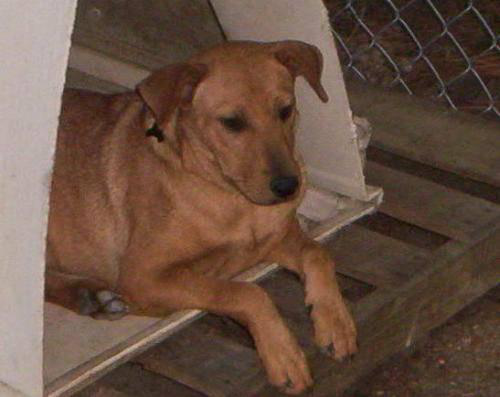


Image: /v3io/bigdata/dogs_vs_cats_sample/cat/cat.1000.jpg
Predicted: cat


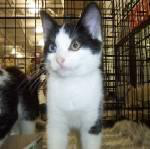

In [17]:
import json
import base64
from io import BytesIO
from PIL import Image
import requests

def encode_image(image_path):
    img = Image.open(image_path)
    im_file = BytesIO()
    img.save(im_file, format="JPEG")
    im_bytes = im_file.getvalue()
    im_b64 = base64.b64encode(im_bytes)
    return im_b64.decode("utf-8")

def decode_image(byte_stream):
    im_bytes = base64.b64decode(byte_stream)
    im_file = BytesIO(im_bytes)
    img = Image.open(im_file)
    return img

addr = "http://3.17.244.7:31394"
dog_img = "/v3io/bigdata/dogs_vs_cats_sample/dog/dog.100.jpg"
cat_img = "/v3io/bigdata/dogs_vs_cats_sample/cat/cat.1000.jpg"
images = [dog_img, cat_img]

payload = {'data': [{'path' : img, 'encoded' : encode_image(img)} for img in images]}

response = requests.post(addr, json=json.dumps(payload))
predictions = response.json()

for image, data in predictions.items():
    pred, encoded = data.values()
    print("Image:", image)
    print("Predicted:", pred)
    display(decode_image(encoded))
    print()